In [1]:
import pandas as pd
import numpy as np
import matplotlib

import glob
from colour import Color

In [9]:
#import ipywidgets as widgets
#%matplotlib widget

import matplotlib.backends.backend_pdf                  as be_pdf
from skimage              import measure                as skm
from scipy.optimize       import curve_fit              as c_fit
from scipy                import ndimage                as nd
from scipy.ndimage        import center_of_mass         as C_O_M
#from mpl_interactions     import ipyplot                as iplt
from mpl_toolkits.mplot3d import Axes3D
from os.path              import isfile, join, isdir
from os import listdir
#import copy,scipy,mpld3,astropy,cmath,math,os,json,yapf.yapflib.yapf_api,shutil,h5py,time,gekko
from numpy.linalg         import norm
#from mpl_interactions     import hyperslicer
from matplotlib           import pyplot                 as plt
from matplotlib           import rcParams               as rc
from datetime             import datetime

import matplotlib.backends.backend_pdf                  as be_pdf
from skimage              import measure                as skm
from scipy.optimize       import curve_fit              as c_fit
from scipy                import ndimage                as nd
from scipy.ndimage        import center_of_mass         as C_O_M
#from mpl_interactions     import ipyplot                as iplt
from mpl_toolkits.mplot3d import Axes3D
from os.path              import isfile, join, isdir
from os import listdir
#import seaborn as sns
from scipy.fftpack import fftn, ifftn, fftshift
rc['text.usetex'] = True
#sns.set_theme()
rc["figure.autolayout"] = True
rc["figure.dpi"] = 150

In [10]:
plt.rcParams.update(plt.rcParamsDefault)

plt.rcParams.update(
    {
        "figure.figsize": (10, 5),
        "figure.facecolor":"w",
        "font.size": 10,
        "axes.grid": True,

    }
)

In [3]:
#Calibration using the Frame_stiffness value

Frame_stiffness= 22000 #N/m

In [4]:
#File caxis Zn

datadir =r'/home/anastasiia/DATA/FemtoTools/CT_C_ZnO_0001Zn_2024-03-26,10h32m18s/data/0001Zn_txt'

os.chdir(datadir)
os.getcwd()
lst=glob.glob("*.txt")


############# Lecture d'un fichier
name=lst[0]
lstnom=["Index","Phase","Displacement","Time","PosX","PosY","PosZ","RotA","RotB","PiezoX","ForceA","ForceB","Gripper","VoltageA","VoltageB","Temperature","SampleDisplacement"]


data0001Zn = pd.read_csv(name, delim_whitespace=True, skiprows=3, encoding='unicode_escape', error_bad_lines=False,names=lstnom,low_memory=False);
data=data0001Zn 

del_test_line=[]
with open(name, 'r', encoding='unicode_escape') as file:
    i=0
    for line in file:
       if len(line.split())==28:
           del_test_line.append(i)
       i+=1     
del_test_line=np.array(del_test_line)



del_test_line=np.where(data0001Zn["ForceA"]=='[uN]')[0]
del_test_line=[*del_test_line,*[len(data0001Zn["ForceA"])+2]] #On ajoute le dernier point +2
len(del_test_line)
# del_test_line= posotion des lignes où les tests commencent + dernier point+2 (necessaire pour le traitement des data)


#Extraction raw data

scan_old=0
ForceA=[]
Displacement_raw=[]
Pos_X=[]
Time=[]
Type=[]
Pos_Y=[]
Pos_Z=[]
for scan in range(len(del_test_line)-1):#wanted_test:
    a,b=del_test_line[scan_old],del_test_line[scan+1]
    ForceA.append( np.nan_to_num(data["ForceA"][a+1:b-2].values.astype(float))[:-1])
    Displacement_raw.append(np.nan_to_num(data["Displacement"][a+1:b-2].values.astype(float))[:-1])
    Pos_X.append(np.nan_to_num(data["PosX"][a+1:b-2].values.astype(float))[:-1])
    Pos_Y.append(np.nan_to_num(data["PosY"][a+1:b-2].values.astype(float))[:-1])
    Pos_Z.append(np.nan_to_num(data["PosZ"][a+1:b-2].values.astype(float))[:-1])
    Time.append(np.nan_to_num(data["Time"][a+1:b-2].values.astype(float))[:-1])
    Type.append(np.nan_to_num(data["Phase"][a+1:b-2].values.astype(float))[:-1])
    scan_old=int(scan+1)
    


#Recalibrating (take into account the frame stiffness)

Displacement=[]
scan_old=0

for scan in range(len(del_test_line)-1):#wanted_test:
    a,b=del_test_line[scan_old],del_test_line[scan+1]
    Displacement.append(np.nan_to_num(data["PiezoX"][a+1:b-2].values.astype(float))[:-1]-
                        1/Frame_stiffness*np.nan_to_num(data["ForceA"][a+1:b-2].values.astype(float))[:-1])
    scan_old=int(scan+1)


#Computation of SampleDisplacement (to be improved)

SampleDisplacement=[]
scan_old=0

for scan in range(len(del_test_line)-1):#wanted_test:
    a,b=del_test_line[scan_old],del_test_line[scan+1]
    surface_position=float(data["PiezoX"][a+2])-float(data["SampleDisplacement"][a+2])
    SampleDisplacement.append(np.nan_to_num(data["PiezoX"][a+1:b-2].values.astype(float))[:-1] -
                              1/Frame_stiffness*np.nan_to_num(data["ForceA"][a+1:b-2].values.astype(float))[:-1] -
                              surface_position)
    scan_old=int(scan+1)
    




C:\Users\solene.da-ville\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


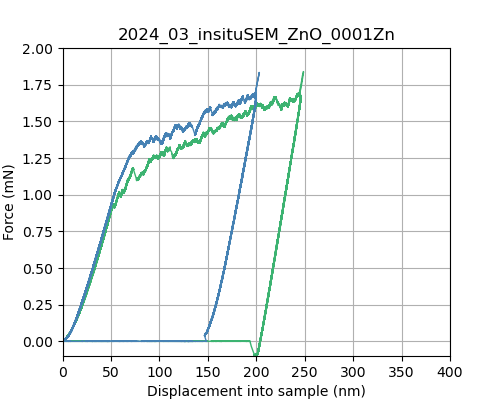

In [5]:
#Graph of selected test
Name='2024_03_insituSEM_ZnO_0001Zn'
Liste_selected_tests=[0,1] #correspond to pillar 2,3
height=[3,3] #microns, hieght of pillar 2,3
top_diameter=[0.7,0.7] #microns, top diamter of pillar 2,3
base_diameter=[1,1] #microns, medium diamter of pillar 2,3

plt.figure(figsize=(5, 4),facecolor=None)

nbre_tests=len(Liste_selected_tests)



scan=Liste_selected_tests[nbre_tests-1]
axes = plt.axes()
axes.set_xlim([0,400])
axes.set_ylim([-0.1,2])
plt.title(Name)
plt.xlabel('Displacement into sample (nm)')
plt.ylabel('Force (mN)')
color1 = Color("mediumseagreen") #cornflowerblue")#Color("navy")
color2=Color("steelblue")
colors = list(color1.range_to(color2,nbre_tests))


#viridis = mpl.colormaps['viridis'].resampled(8)
#coloration=viridis(range(nbre_tests))

Selected_SampleDisplacement=[]
Selected_Force=[]


for i in range (nbre_tests):
    scan=Liste_selected_tests[i]
    Selected_Force.append(0.001*ForceA[scan])
    Selected_SampleDisplacement.append(1000*SampleDisplacement[scan])
    plt.plot(1000*SampleDisplacement[scan],0.001*ForceA[scan],c=colors[i].hex,linewidth=1)

plt.savefig('LoadVSDispOntoSample_'+Name+'.png')
plt.show()
    

In [6]:
#File 0001O

datadir =r'C:\Users\solene.da-ville\Desktop\Recherche\Projets\ZnO photo plasticité\Essais piliers FIB mars 2024\DATA\FemtoTools\CT_C_0001O_2024-03-28,14h14m21s\data'

os.chdir(datadir)
os.getcwd()
lst=glob.glob("*.txt")


############# Lecture d'un fichier
name=lst[0]
lstnom=["Index","Phase","Displacement","Time","PosX","PosY","PosZ","RotA","RotB","PiezoX","ForceA","ForceB","Gripper","VoltageA","VoltageB","Temperature","SampleDisplacement"]


data0001O = pd.read_csv(name, delim_whitespace=True, skiprows=3, encoding='unicode_escape', error_bad_lines=False,names=lstnom,low_memory=False);
data=data0001O 

del_test_line=[]
with open(name, 'r', encoding='unicode_escape') as file:
    i=0
    for line in file:
       if len(line.split())==28:
           del_test_line.append(i)
       i+=1     
del_test_line=np.array(del_test_line)



del_test_line=np.where(data["ForceA"]=='[uN]')[0]
del_test_line=[*del_test_line,*[len(data["ForceA"])+2]] #On ajoute le dernier point +2
len(del_test_line)
# del_test_line= posotion des lignes où les tests commencent + dernier point+2 (necessaire pour le traitement des data)


#Extraction raw data

scan_old=0
#ForceA=[]
#Displacement_raw=[]
#Pos_X=[]
#Time=[]
#Type=[]
#Pos_Y=[]
#Pos_Z=[]
for scan in range(len(del_test_line)-1):#wanted_test:
    a,b=del_test_line[scan_old],del_test_line[scan+1]
    ForceA.append( np.nan_to_num(data["ForceA"][a+1:b-2].values.astype(float))[:-1])
    Displacement_raw.append(np.nan_to_num(data["Displacement"][a+1:b-2].values.astype(float))[:-1])
    Pos_X.append(np.nan_to_num(data["PosX"][a+1:b-2].values.astype(float))[:-1])
    Pos_Y.append(np.nan_to_num(data["PosY"][a+1:b-2].values.astype(float))[:-1])
    Pos_Z.append(np.nan_to_num(data["PosZ"][a+1:b-2].values.astype(float))[:-1])
    Time.append(np.nan_to_num(data["Time"][a+1:b-2].values.astype(float))[:-1])
    Type.append(np.nan_to_num(data["Phase"][a+1:b-2].values.astype(float))[:-1])
    scan_old=int(scan+1)
    


#Recalibrating (take into account the frame stiffness)

#Displacement=[]
scan_old=0

for scan in range(len(del_test_line)-1):#wanted_test:
    a,b=del_test_line[scan_old],del_test_line[scan+1]
    Displacement.append(np.nan_to_num(data["PiezoX"][a+1:b-2].values.astype(float))[:-1]-1/Frame_stiffness*np.nan_to_num(data["ForceA"][a+1:b-2].values.astype(float))[:-1])
    scan_old=int(scan+1)


#Computation of SampleDisplacement (to be improved)

#SampleDisplacement=[]
scan_old=0

for scan in range(len(del_test_line)-1):#wanted_test:
    a,b=del_test_line[scan_old],del_test_line[scan+1]
    surface_position=float(data["PiezoX"][a+2])-float(data["SampleDisplacement"][a+2])
    SampleDisplacement.append(np.nan_to_num(data["PiezoX"][a+1:b-2].values.astype(float))[:-1]-1/Frame_stiffness*np.nan_to_num(data["ForceA"][a+1:b-2].values.astype(float))[:-1]-surface_position)
    scan_old=int(scan+1)
    



C:\Users\solene.da-ville\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


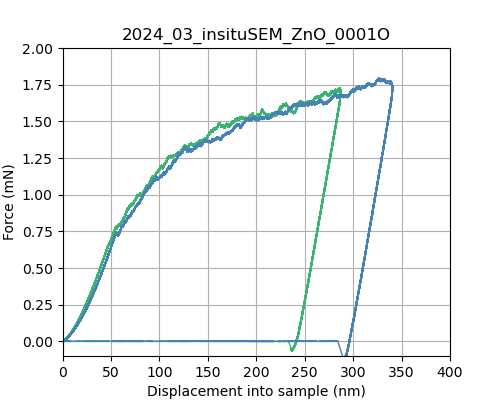

In [7]:
#Graph of selected test
Name='2024_03_insituSEM_ZnO_0001O'
Liste_selected_tests=[2,3]
height=[3,3] #microns
top_diameter=[0.7,0.7] #microns
base_diameter=[1,1] #microns

plt.figure(figsize=(5, 4),facecolor=None)

nbre_tests=len(Liste_selected_tests)



axes = plt.axes()
axes.set_xlim([0,400])
axes.set_ylim([-0.1,2])
plt.title(Name)
plt.xlabel('Displacement into sample (nm)')
plt.ylabel('Force (mN)')
color1 = Color("mediumseagreen") #cornflowerblue")#Color("navy")
color2=Color("steelblue")
colors = list(color1.range_to(color2,nbre_tests))


#viridis = mpl.colormaps['viridis'].resampled(8)
#coloration=viridis(range(nbre_tests))


for i in range (nbre_tests):
    scan=Liste_selected_tests[i]
    Selected_Force.append(0.001*ForceA[scan])
    Selected_SampleDisplacement.append(1000*SampleDisplacement[scan])
    plt.plot(1000*SampleDisplacement[scan],0.001*ForceA[scan],c=colors[i].hex,linewidth=1)

plt.savefig('LoadVSDispOntoSample_'+Name+'.png')
plt.show()
    

In [8]:
#File 10-10

datadir =r'C:\Users\solene.da-ville\Desktop\Recherche\Projets\ZnO photo plasticité\Essais piliers FIB mars 2024\DATA\FemtoTools\CT_C_10-10_2024-03-27,11h55m47s\data'

os.chdir(datadir)
os.getcwd()
lst=glob.glob("*.txt")


############# Lecture d'un fichier
name=lst[0]
lstnom=["Index","Phase","Displacement","Time","PosX","PosY","PosZ","RotA","RotB","PiezoX","ForceA","ForceB","Gripper","VoltageA","VoltageB","Temperature","SampleDisplacement"]


data10m10 = pd.read_csv(name, delim_whitespace=True, skiprows=3, encoding='unicode_escape', error_bad_lines=False,names=lstnom,low_memory=False);
data=data10m10 

del_test_line=[]
with open(name, 'r', encoding='unicode_escape') as file:
    i=0
    for line in file:
       if len(line.split())==28:
           del_test_line.append(i)
       i+=1     
del_test_line=np.array(del_test_line)



del_test_line=np.where(data["ForceA"]=='[uN]')[0]
del_test_line=[*del_test_line,*[len(data["ForceA"])+2]] #On ajoute le dernier point +2
len(del_test_line)
# del_test_line= posotion des lignes où les tests commencent + dernier point+2 (necessaire pour le traitement des data)


#Extraction raw data

scan_old=0
ForceA=[]
Displacement_raw=[]
Pos_X=[]
Time=[]
Type=[]
Pos_Y=[]
Pos_Z=[]
for scan in range(len(del_test_line)-1):#wanted_test:
    a,b=del_test_line[scan_old],del_test_line[scan+1]
    ForceA.append( np.nan_to_num(data["ForceA"][a+1:b-2].values.astype(float))[:-1])
    Displacement_raw.append(np.nan_to_num(data["Displacement"][a+1:b-2].values.astype(float))[:-1])
    Pos_X.append(np.nan_to_num(data["PosX"][a+1:b-2].values.astype(float))[:-1])
    Pos_Y.append(np.nan_to_num(data["PosY"][a+1:b-2].values.astype(float))[:-1])
    Pos_Z.append(np.nan_to_num(data["PosZ"][a+1:b-2].values.astype(float))[:-1])
    Time.append(np.nan_to_num(data["Time"][a+1:b-2].values.astype(float))[:-1])
    Type.append(np.nan_to_num(data["Phase"][a+1:b-2].values.astype(float))[:-1])
    scan_old=int(scan+1)
    


#Recalibrating (take into account the frame stiffness)

Displacement=[]
scan_old=0

for scan in range(len(del_test_line)-1):#wanted_test:
    a,b=del_test_line[scan_old],del_test_line[scan+1]
    Displacement.append(np.nan_to_num(data["PiezoX"][a+1:b-2].values.astype(float))[:-1]-1/Frame_stiffness*np.nan_to_num(data["ForceA"][a+1:b-2].values.astype(float))[:-1])
    scan_old=int(scan+1)


#Computation of SampleDisplacement (to be improved)

SampleDisplacement=[]
scan_old=0

for scan in range(len(del_test_line)-1):#wanted_test:
    a,b=del_test_line[scan_old],del_test_line[scan+1]
    surface_position=float(data["PiezoX"][a+2])-float(data["SampleDisplacement"][a+2])
    SampleDisplacement.append(np.nan_to_num(data["PiezoX"][a+1:b-2].values.astype(float))[:-1]-1/Frame_stiffness*np.nan_to_num(data["ForceA"][a+1:b-2].values.astype(float))[:-1]-surface_position)
    scan_old=int(scan+1)
    


    

C:\Users\solene.da-ville\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


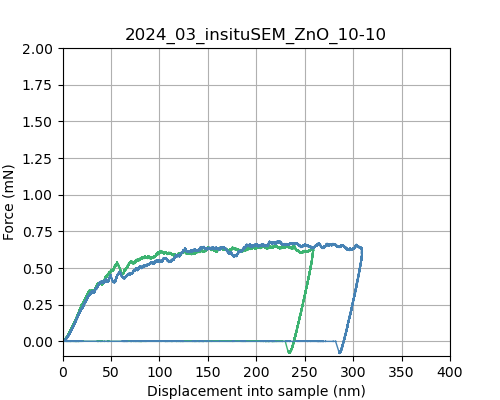

In [9]:
#Graph of selected test
Name='2024_03_insituSEM_ZnO_10-10'
Liste_selected_tests=[0,1]
height=[3,3] #microns
top_diameter=[0.7,0.7] #microns
base_diameter=[1,1] #microns

plt.figure(figsize=(5, 4),facecolor=None)

nbre_tests=len(Liste_selected_tests)



scan=Liste_selected_tests[nbre_tests-1]
axes = plt.axes()
axes.set_xlim([0,400])
axes.set_ylim([-0.1,2])
plt.title(Name)
plt.xlabel('Displacement into sample (nm)')
plt.ylabel('Force (mN)')
color1 = Color("mediumseagreen") #cornflowerblue")#Color("navy")
color2=Color("steelblue")
colors = list(color1.range_to(color2,nbre_tests))


#viridis = mpl.colormaps['viridis'].resampled(8)
#coloration=viridis(range(nbre_tests))


for i in range (nbre_tests):
    scan=Liste_selected_tests[i]
    Selected_Force.append(0.001*ForceA[scan])
    Selected_SampleDisplacement.append(1000*SampleDisplacement[scan])
    plt.plot(1000*SampleDisplacement[scan],0.001*ForceA[scan],c=colors[i].hex,linewidth=1)

plt.savefig('LoadVSDispOntoSample_'+Name+'.png')
plt.show()

In [10]:
#File 11-20

datadir =r'C:\Users\solene.da-ville\Desktop\Recherche\Projets\ZnO photo plasticité\Essais piliers FIB mars 2024\DATA\FemtoTools\CT_C_11-20_2024-03-28,09h40m17s\data'

os.chdir(datadir)
os.getcwd()
lst=glob.glob("*.txt")


############# Lecture d'un fichier
name=lst[0]
lstnom=["Index","Phase","Displacement","Time","PosX","PosY","PosZ","RotA","RotB","PiezoX","ForceA","ForceB","Gripper","VoltageA","VoltageB","Temperature","SampleDisplacement"]


data11m20 = pd.read_csv(name, delim_whitespace=True, skiprows=3, encoding='unicode_escape', error_bad_lines=False,names=lstnom,low_memory=False);
data=data11m20 

del_test_line=[]
with open(name, 'r', encoding='unicode_escape') as file:
    i=0
    for line in file:
       if len(line.split())==28:
           del_test_line.append(i)
       i+=1     
del_test_line=np.array(del_test_line)



del_test_line=np.where(data["ForceA"]=='[uN]')[0]
del_test_line=[*del_test_line,*[len(data["ForceA"])+2]] #On ajoute le dernier point +2
len(del_test_line)
# del_test_line= posotion des lignes où les tests commencent + dernier point+2 (necessaire pour le traitement des data)


#Extraction raw data

scan_old=0
ForceA=[]
Displacement_raw=[]
Pos_X=[]
Time=[]
Type=[]
Pos_Y=[]
Pos_Z=[]
for scan in range(len(del_test_line)-1):#wanted_test:
    a,b=del_test_line[scan_old],del_test_line[scan+1]
    ForceA.append( np.nan_to_num(data["ForceA"][a+1:b-2].values.astype(float))[:-1])
    Displacement_raw.append(np.nan_to_num(data["Displacement"][a+1:b-2].values.astype(float))[:-1])
    Pos_X.append(np.nan_to_num(data["PosX"][a+1:b-2].values.astype(float))[:-1])
    Pos_Y.append(np.nan_to_num(data["PosY"][a+1:b-2].values.astype(float))[:-1])
    Pos_Z.append(np.nan_to_num(data["PosZ"][a+1:b-2].values.astype(float))[:-1])
    Time.append(np.nan_to_num(data["Time"][a+1:b-2].values.astype(float))[:-1])
    Type.append(np.nan_to_num(data["Phase"][a+1:b-2].values.astype(float))[:-1])
    scan_old=int(scan+1)
    


#Recalibrating (take into account the frame stiffness)

Displacement=[]
scan_old=0

for scan in range(len(del_test_line)-1):#wanted_test:
    a,b=del_test_line[scan_old],del_test_line[scan+1]
    Displacement.append(np.nan_to_num(data["PiezoX"][a+1:b-2].values.astype(float))[:-1]-1/Frame_stiffness*np.nan_to_num(data["ForceA"][a+1:b-2].values.astype(float))[:-1])
    scan_old=int(scan+1)


#Computation of SampleDisplacement (to be improved)

SampleDisplacement=[]
scan_old=0

for scan in range(len(del_test_line)-1):#wanted_test:
    a,b=del_test_line[scan_old],del_test_line[scan+1]
    surface_position=float(data["PiezoX"][a+2])-float(data["SampleDisplacement"][a+2])
    SampleDisplacement.append(np.nan_to_num(data["PiezoX"][a+1:b-2].values.astype(float))[:-1]-1/Frame_stiffness*np.nan_to_num(data["ForceA"][a+1:b-2].values.astype(float))[:-1]-surface_position)
    scan_old=int(scan+1)
    


    

C:\Users\solene.da-ville\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


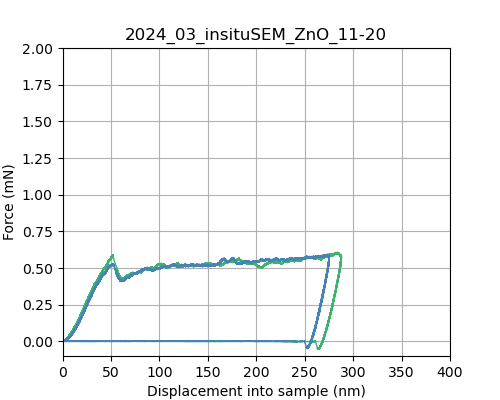

In [11]:
#Graph of selected test
Name='2024_03_insituSEM_ZnO_11-20'
Liste_selected_tests=[0,1]
height=[3,3] #microns
top_diameter=[0.7,0.7] #microns
base_diameter=[1,1] #microns

plt.figure(figsize=(5, 4),facecolor=None)

nbre_tests=len(Liste_selected_tests)



scan=Liste_selected_tests[nbre_tests-1]
axes = plt.axes()
axes.set_xlim([0,400])
axes.set_ylim([-0.1,2])
plt.title(Name)
plt.xlabel('Displacement into sample (nm)')
plt.ylabel('Force (mN)')
color1 = Color("mediumseagreen") #cornflowerblue")#Color("navy")
color2=Color("steelblue")
colors = list(color1.range_to(color2,nbre_tests))


#viridis = mpl.colormaps['viridis'].resampled(8)
#coloration=viridis(range(nbre_tests))


for i in range (nbre_tests):
    scan=Liste_selected_tests[i]
    Selected_Force.append(0.001*ForceA[scan])
    Selected_SampleDisplacement.append(1000*SampleDisplacement[scan])
    plt.plot(1000*SampleDisplacement[scan],0.001*ForceA[scan],c=colors[i].hex,linewidth=1)

plt.savefig('LoadVSDispOntoSample_'+Name+'.png')
plt.show()

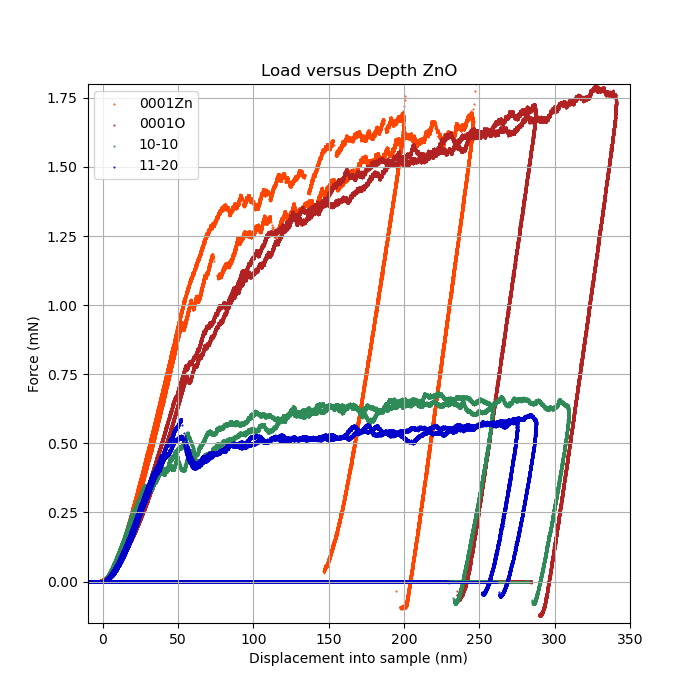

In [30]:
Name='Load versus Depth ZnO'

nbre_orientation=4
nbre_tests=8

plt.figure(figsize=(7, 7),facecolor=None)
axes = plt.axes()
axes.set_xlim([-10,350])
axes.set_ylim([-0.15,1.8])
plt.title(Name)
plt.xlabel('Displacement into sample (nm)')
plt.ylabel('Force (mN)')
color1 = Color("orangered") #cornflowerblue")#Color("navy")
color2=Color("firebrick")
color3=Color("seagreen")
color4=Color("mediumblue")
colors = [color1,color2,color3,color4]


#viridis = mpl.colormaps['viridis'].resampled(8)
#coloration=viridis(range(nbre_tests))

plt.scatter(Selected_SampleDisplacement[0],Selected_Force[0],c=color1.hex,marker=".",label="0001Zn",s=1)
plt.scatter(Selected_SampleDisplacement[1],Selected_Force[1],c=color1.hex,marker=".",s=1)
plt.scatter(Selected_SampleDisplacement[2],Selected_Force[2],c=color2.hex,marker=".",label="0001O",s=1)
plt.scatter(Selected_SampleDisplacement[3],Selected_Force[3],c=color2.hex,marker=".",s=1)
plt.scatter(Selected_SampleDisplacement[4],Selected_Force[4],c=color3.hex,marker=".",label="10-10",s=1)
plt.scatter(Selected_SampleDisplacement[5],Selected_Force[5],c=color3.hex,marker=".",s=1)
plt.scatter(Selected_SampleDisplacement[6],Selected_Force[6],c=color4.hex,marker=".",label="11-20",s=1)
plt.scatter(Selected_SampleDisplacement[7],Selected_Force[7],c=color4.hex,marker=".",s=1)

axes.legend()  
# Plot legend.
#lgnd = plt.legend(loc="lower left", numpoints=1, fontsize=10)

#change the marker size manually for both lines
#lgnd.legendHandles[0]._legmarker.set_markersize(6)
#lgnd.legendHandles[1]._legmarker.set_markersize(6)    
    
    
plt.savefig('All_'+Name+'.png')
plt.show()


In [88]:
plt.rcParams.update(plt.rcParamsDefault)

plt.rcParams.update(
    {
        "figure.figsize": (10, 5),
        "figure.facecolor":"w",
        "font.size": 10,
        "axes.grid": True,

    }
)

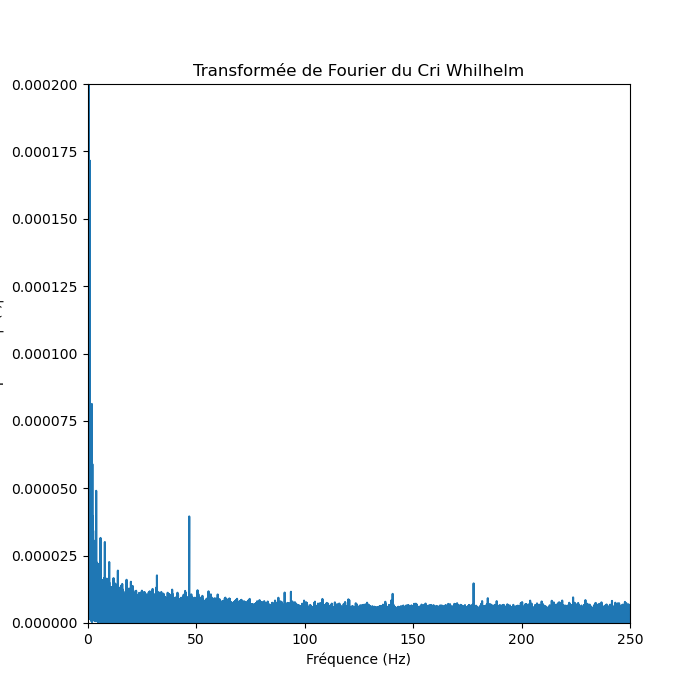

In [116]:
from numpy.fft import fft, fftfreq
plt.figure(figsize=(7, 7),facecolor=None)

dt=1./500
x=Selected_Force[7]

# Calcul FFT
X = fft(x)  # Transformée de fourier
freq = fftfreq(x.size, d=dt)  # Fréquences de la transformée de Fourier

# Calcul du nombre d'échantillon
N = x.size

# On prend la valeur absolue de l'amplitude uniquement pour les fréquences positives et normalisation
X_abs = np.abs(X[:N//2])*2.0/N
# On garde uniquement les fréquences positives
freq_pos = freq[:N//2]

plt.plot(freq_pos, X_abs, label="Amplitude absolue")
plt.xlim(0, 250)  # On réduit la plage des fréquences à la zone utile
plt.ylim(0, 0.0002)  # On réduit la plage des fréquences à la zone utile
plt.grid()
plt.xlabel(r"Fréquence (Hz)")
plt.ylabel(r"Amplitude $|X(f)|$")
plt.title("Transformée de Fourier du Cri Whilhelm")
plt.show()

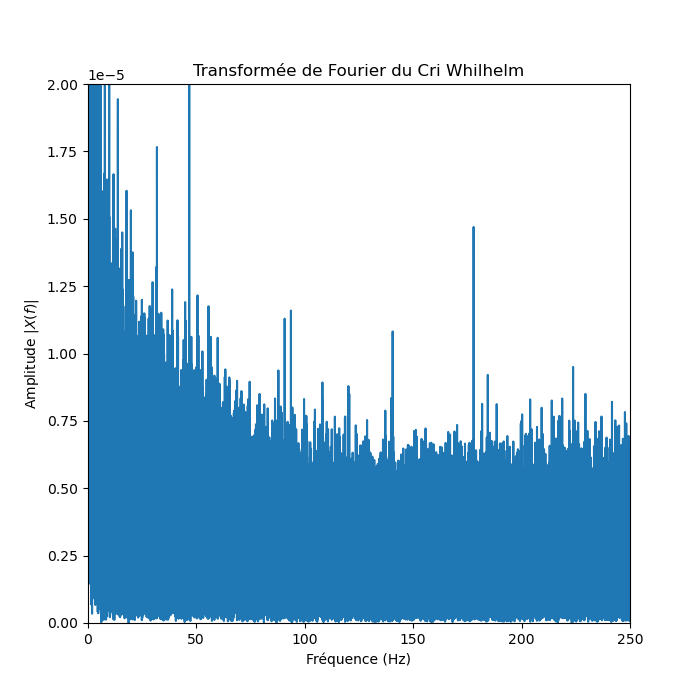

In [112]:
from numpy.fft import fft, fftfreq
plt.figure(figsize=(7, 7),facecolor=None)

dt=1./500
x=Selected_Force[7]

# Calcul FFT
X = fft(x)  # Transformée de fourier
freq = fftfreq(x.size, d=dt)  # Fréquences de la transformée de Fourier

# Calcul du nombre d'échantillon
N = x.size

# On prend la valeur absolue de l'amplitude uniquement pour les fréquences positives et normalisation
X_abs = np.abs(X[:N//2])*2.0/N
# On garde uniquement les fréquences positives
freq_pos = freq[:N//2]

plt.plot(freq_pos, X_abs, label="Amplitude absolue")
plt.xlim(0, 250)  # On réduit la plage des fréquences à la zone utile
plt.ylim(0, 0.00002)  # On réduit la plage des fréquences à la zone utile
plt.grid()
plt.xlabel(r"Fréquence (Hz)")
plt.ylabel(r"Amplitude $|X(f)|$")
plt.title("Transformée de Fourier du Cri Whilhelm")
plt.show()